In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [137]:
# Pkg.instantiate()
# Pkg.update()

In [2]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")
include("velocity_obstacles.jl")

reactive_velocity_obstacles (generic function with 1 method)

### Interaction planner

In [3]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.1]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [4]:
robot_initial_state = [5.; 5.; -pi / 2.; 0.]
robot_goal_state = [5.; -5.; -pi / 2; 0.]
human_initial_state = [5.; -5.; pi / 2]
human_goal_state = [5.; 5.; pi / 2]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [5]:
# Adds a wall constraint to the planner
wall_1 = Wall("x", 0., 6.1, "less")
wall_constraint(ip, wall_1, "wall_1")
wall_2 = Wall("x", 0.1, 3.2, "greater")
wall_constraint(ip, wall_2, "wall_2")

26-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 x[1,1] - 0.1 x[1,2] ≥ 4.2
 x[2,1] - 0.1 x[2,2] ≥ 4.2
 x[3,1] - 0.1 x[3,2] ≥ 4.2
 x[4,1] - 0.1 x[4,2] ≥ 4.2
 x[5,1] - 0.1 x[5,2] ≥ 4.2
 x[6,1] - 0.1 x[6,2] ≥ 4.2
 x[7,1] - 0.1 x[7,2] ≥ 4.2
 x[8,1] - 0.1 x[8,2] ≥ 4.2
 x[9,1] - 0.1 x[9,2] ≥ 4.2
 x[10,1] - 0.1 x[10,2] ≥ 4.2
 ⋮
 x[18,1] - 0.1 x[18,2] ≥ 4.2
 x[19,1] - 0.1 x[19,2] ≥ 4.2
 x[20,1] - 0.1 x[20,2] ≥ 4.2
 x[21,1] - 0.1 x[21,2] ≥ 4.2
 x[22,1] - 0.1 x[22,2] ≥ 4.2
 x[23,1] - 0.1 x[23,2] ≥ 4.2
 x[24,1] - 0.1 x[24,2] ≥ 4.2
 x[25,1] - 0.1 x[25,2] ≥ 4.2
 x[26,1] - 0.1 x[26,2] ≥ 4.2

In [6]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  1.085021 seconds (1.18 M allocations: 87.869 MiB, 6.53% gc time, 83.10% compilation time: 40% of which was recompilation)


  0.138026 seconds (418.10 k allocations: 38.751 MiB, 17.99% gc time)


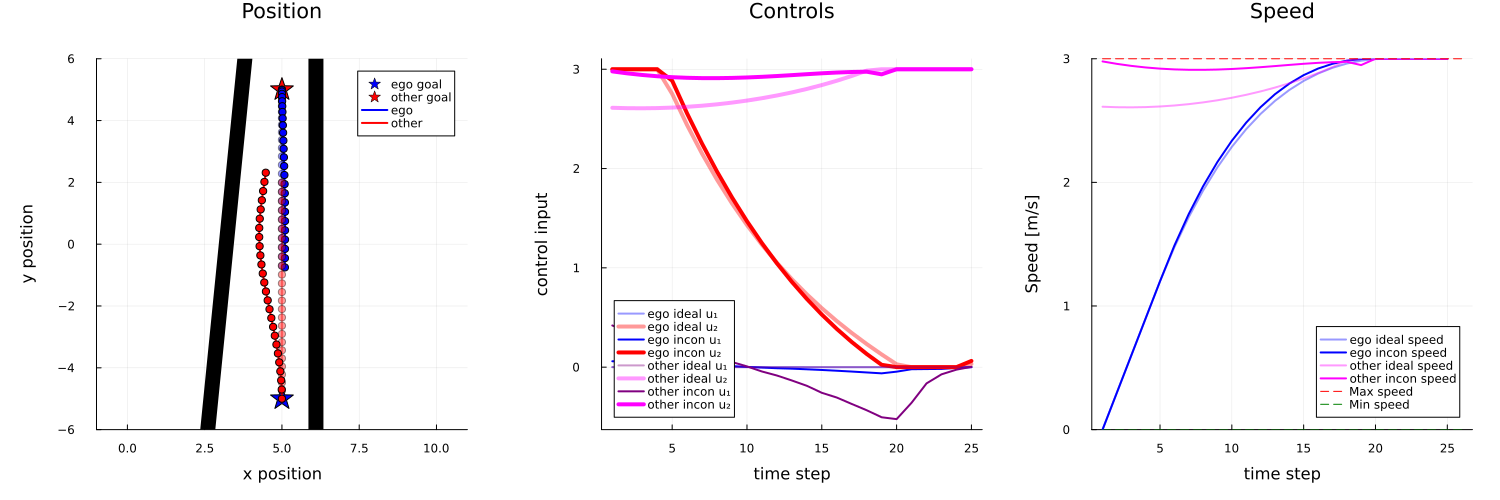

In [7]:
plot_solve_solution(ip, walls=[wall_1, wall_2], pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [8]:
@time ibr(ip, 3, "ego")

  0.086235 seconds (268.86 k allocations: 24.861 MiB)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


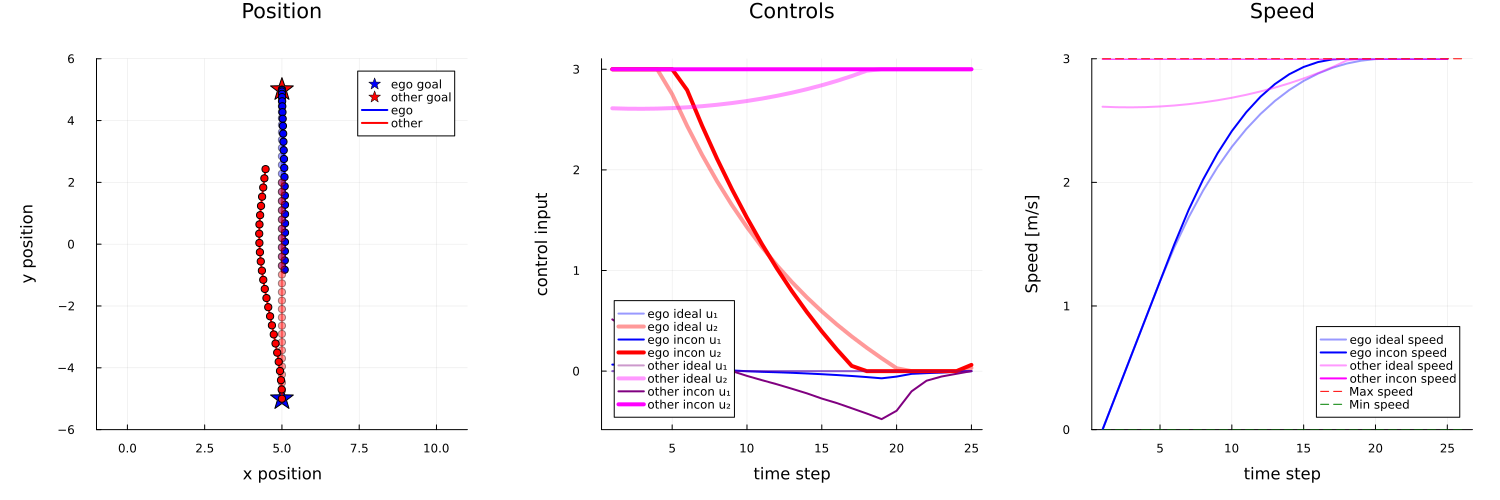

In [9]:
plot_solve_solution(ip, pos_xlims=[-1, 11], walls=nothing, pos_ylims=[-6, 6])

# Animation

┌ Info: Saved animation to /tmp/jl_ibMD2ZaXWr.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_ibMD2ZaXWr.gif")
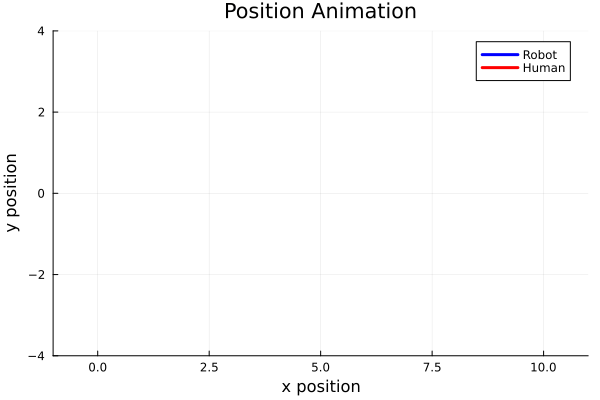

In [146]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

┌ Info: Saved animation to /tmp/jl_gJi92lgRSX.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_gJi92lgRSX.gif")
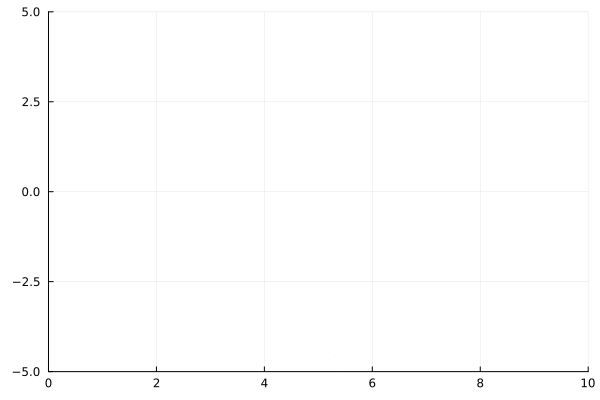

In [147]:
avoidance_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [148]:
include("sim.jl")
include("mpc.jl")

mpc_step (generic function with 2 methods)

In [522]:
solver = "ECOS"

time_horizon = 25
dt = 0.1
velocity_max = 1.5

human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([20.; 20.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 0.9
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5

robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([20.; 20.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [20.0 0.0; 0.0 20.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 0.9
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [523]:
robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [524]:
dt = 0.1
velocity_max = 1.5
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

time_horizon = 25
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.3]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.0
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1] 
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.0
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [525]:
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [526]:
robot_path, robot_controls, human_path, human_controls, solve_times = simulate(robot_ip, human_ip, 75, leader="ego")

([0.0 0.0 0.0 0.0; 0.0036720919785481368 0.0 -3.866229805812353e-13 0.07344183957096272; … ; 8.881527448936454 0.333678358954957 -0.0722075200752711 1.3444124431921571; 9.01475940389812 0.32371363317120017 -0.07710935067518454 1.327671786325431], [-3.866229805812353e-12 0.7344183957096272; 1.2572566241726643e-9 0.7174170339525833; … ; -0.04692394796203076 -0.16044470159473143; -0.049018305999134364 -0.16740656866726067], [10.0 0.0 3.141592653589793 0.0; 9.991945186665184 9.864301368211031e-19 3.141580201930455 0.16109626669630692; … ; 0.49616046203296554 -0.11277642743078913 2.9376746837649548 0.7793078220703202; 0.4215986952539428 -0.09727901765323799 2.935637072092346 0.7437980549134467], [-0.00012451659338482145 1.610962666963069; 0.11041436990283393 1.4381049178306446; … ; -0.02035210093755977 -0.3698839182340707; -0.020376116726088165 -0.3550976715687348], ([0.10521888732910156, 0.09750103950500488, 0.10442495346069336, 0.10245704650878906, 0.09983396530151367, 0.1355891227722168,

┌ Info: Saved animation to /tmp/jl_0fYr0Tyb29.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_0fYr0Tyb29.gif")
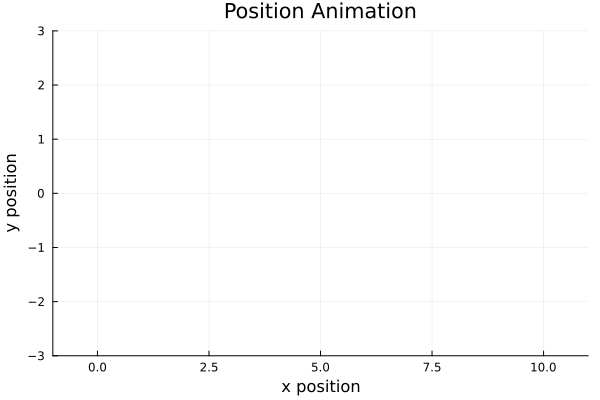

In [509]:
animation(robot_path, human_path, pos_xlims=[-1, 11])

┌ Info: Saved animation to /tmp/jl_6FMtwBiBWv.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_6FMtwBiBWv.gif")
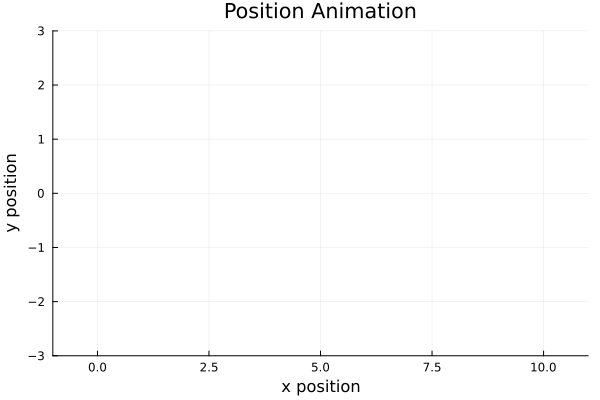

In [527]:
animation(robot_path, human_path, pos_xlims=[-1, 11])

In [156]:
sum(solve_times[1]) / 50

0.12157703399658203

In [157]:
findmax(solve_times[1] )

(0.13428306579589844, 16)

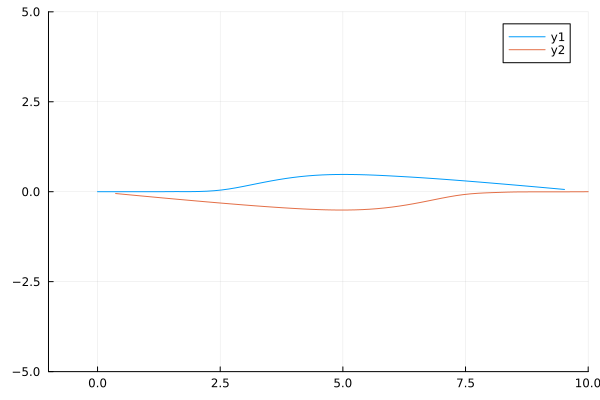

In [158]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-1, 10], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

┌ Info: Saved animation to /tmp/jl_ITWnk3idMx.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_ITWnk3idMx.gif")
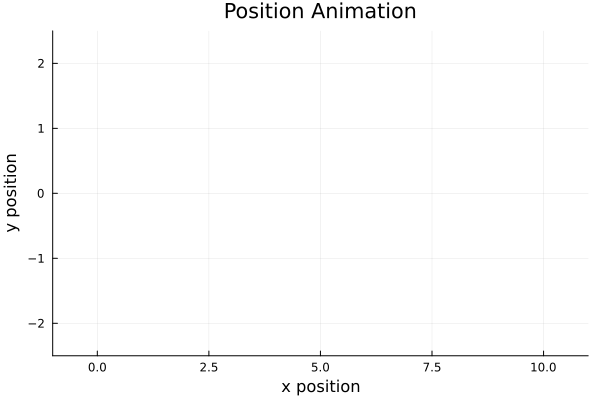

In [159]:
animation(robot_path, human_path, pos_xlims=[-1, 11], pos_ylims=[-2.5, 2.5])

# Summary Plots

### Setup the planner

In [426]:
dt = 0.1
velocity_max = 2.
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 2.])

time_horizon = 60
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([5.; 5.]) 
Qt = diagm([10.; 10.; 0.; 10.])
markup = 1.02
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 2.
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 2.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([5.; 5.0]) 
Qt = diagm([10.; 10.; 0.; 10.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio,
                             collision_markup=1.)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 60
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [5.0 0.0; 0.0 5.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 10.0]
  markup: Float64 1.02
  collision_slack: Float64 150.0
  collision_markup: Float64 1.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [427]:
robot_initial_state = [-5.; 0.; 0.; 1.]
robot_goal_state = [10.; 0.; 0.; 1.]
human_initial_state = [15.; 0.; pi; 1.]
human_goal_state = [0.; 0.; pi; 1.]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [428]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);

  0.273966 seconds (1.01 M allocations: 102.628 MiB, 16.07% gc time)


  0.300057 seconds (1.01 M allocations: 102.649 MiB, 9.00% gc time)


In [429]:
@time saved_data_test, _, _, _, _ = ibr_save(ip, 5, "ego")

  0.384618 seconds (1.32 M allocations: 123.971 MiB, 13.29% gc time)


(SaveData
  previous_ips: Array{InteractionPlanner}((5,))
, [[-5.000000000104282 -4.705525670432599e-11 -3.785864166574896e-11 0.999999999667708; -4.895112890459668 0.00037301147974790955 0.007010028067244659 1.0977584885118767; … ; 6.070441340266336 0.7867337386269276 0.010370128694179925 1.9967132466516697; 6.270095236483884 0.788811692904484 0.010493579396279627 1.9917834565387538], [-5.000000000025034 -4.8452281455703696e-11 -4.761606327997251e-11 0.9999999998510225; -4.894871457860003 0.0004547067608051917 0.00851653800072408 1.1025960410218703; … ; 6.1094257118011885 0.6438059405172046 -0.010126755048135901 1.99673351105673; 6.308884286641446 0.6417866182998434 -0.010049931141261223 1.991804686267637], [-5.000000000149327 -3.5362150598292514e-11 2.1597486605450168e-12 0.9999999997100699; -4.894670748038141 0.000508313068753651 0.009494133635945286 1.1066171330214438; … ; 6.139655260707832 0.5438632697083856 -0.019345486224880186 1.9967148264289942; 6.3390513056693685 0.5400054082

In [380]:
include("plotting.jl")

avoidance_animation (generic function with 1 method)

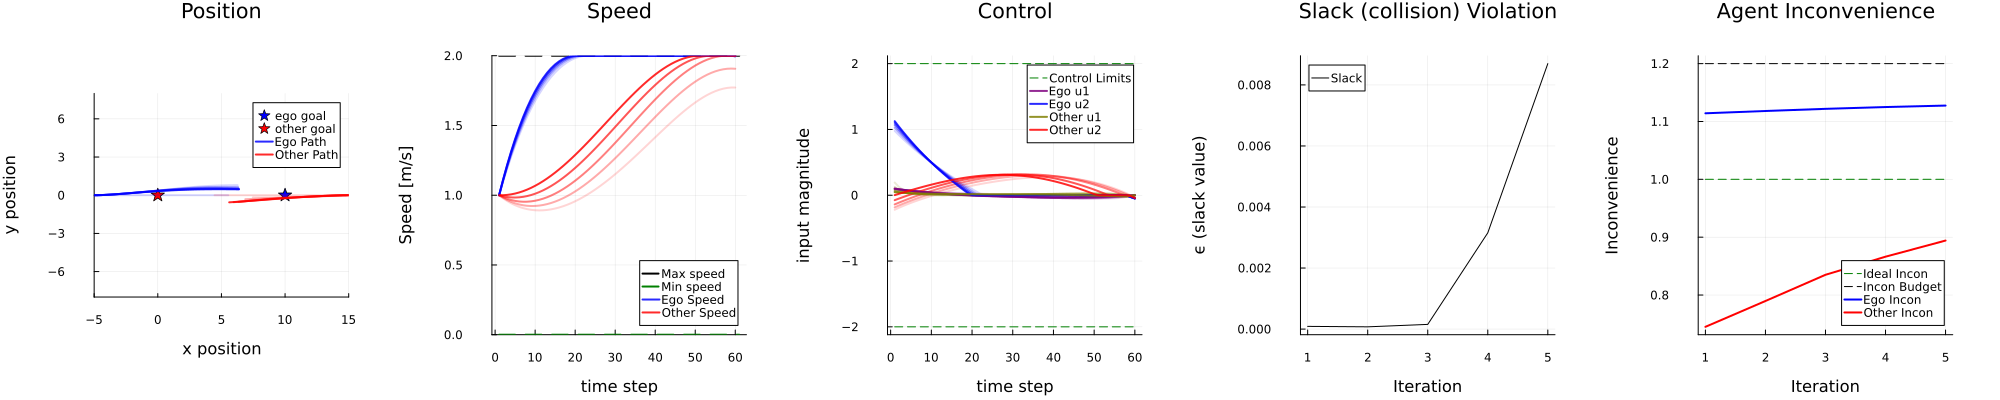

In [430]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true, pos_xlims=[-5, 15], pos_ylims=[-8, 8])

In [432]:
θs = saved_data_test.previous_ips[5].ego_planner.

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


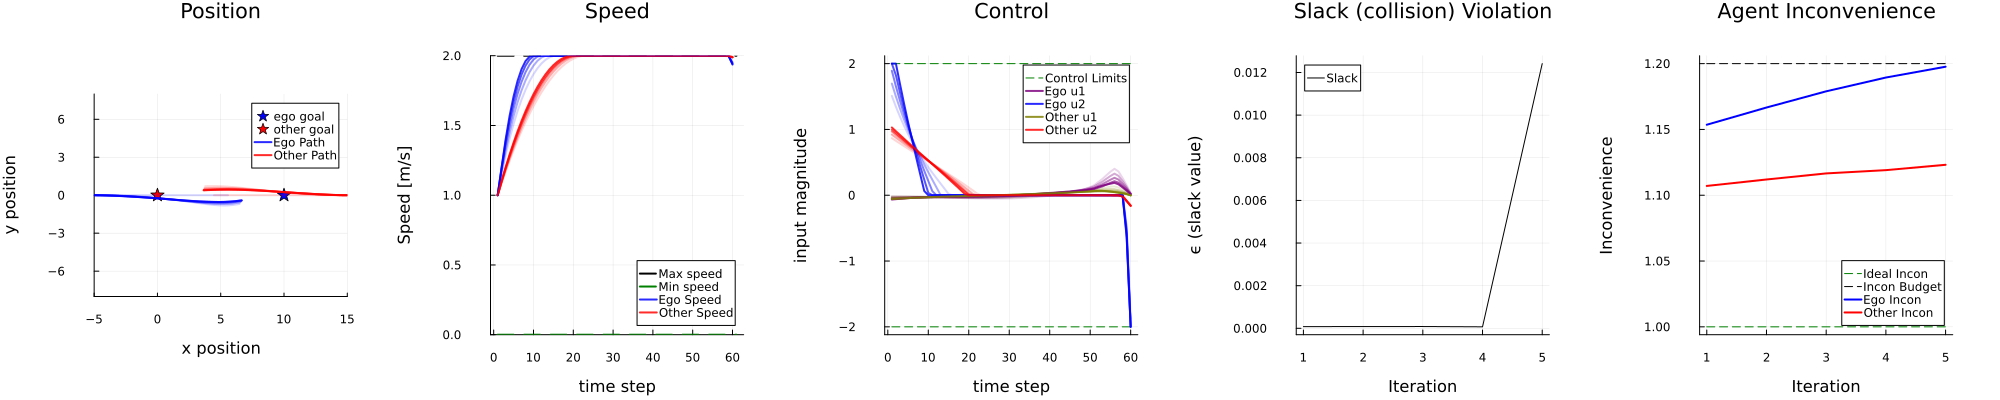

In [420]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true, pos_xlims=[-5, 15], pos_ylims=[-8, 8])

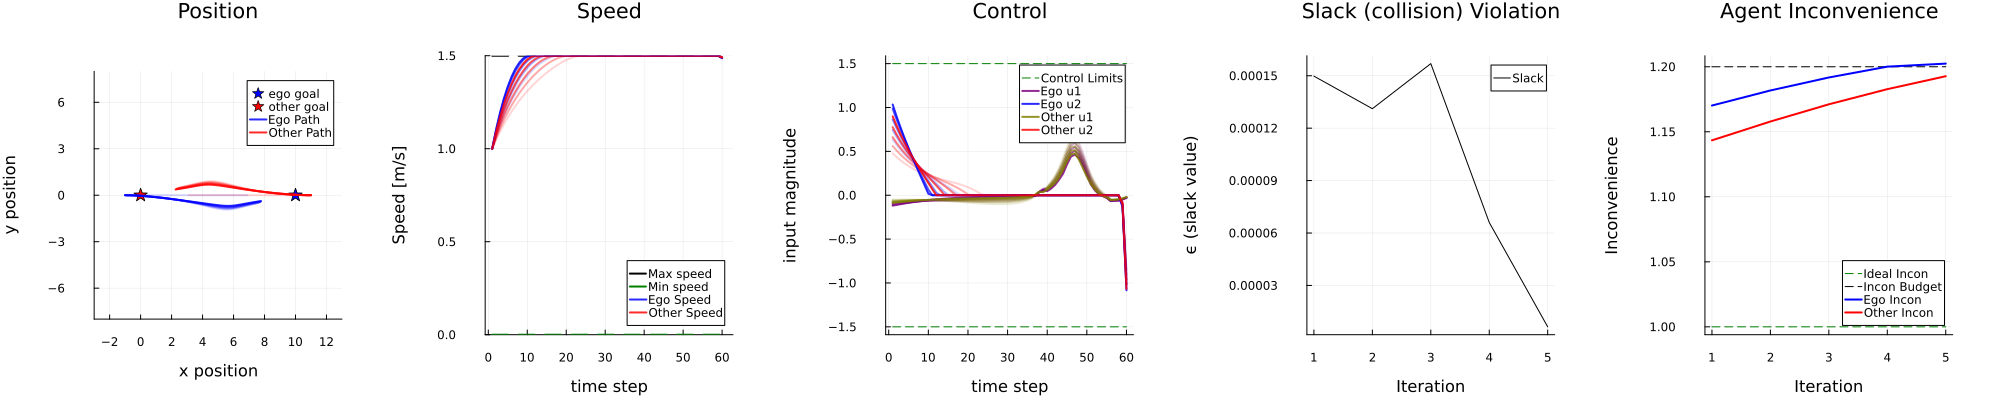

In [395]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true, pos_xlims=[-3, 13], pos_ylims=[-8, 8])

# Sim Experimentation Utils

In [ ]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params, robot_ip.other_planner.incon.hps, robot_ip.other_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params, human_ip.other_planner.incon.hps, human_ip.other_planner.incon.opt_params)

In [ ]:
sim_params = IPSimParams(robot_params, human_params)

In [ ]:
# robot_xs, robot_us, human_xs, human_us, solve_times = simulate(robot_ip, human_ip, 50, ibr_iterations=2, leader="other")

In [ ]:
sim_data = SimData(sim_params, solve_times, robot_path, robot_controls, human_path, human_controls)

In [ ]:
plot_solve_solution(sim_data)

In [ ]:
sim_data.solve_times

# Experimentation Code

In [ ]:
# for experiment in experiments
#     set up problem. Assign hyperparameters. Cycle through hps for each experiment
#     (markup, collision slack, trust region weights, incon weights, collision radius, incon ratio)
#     for opt_param in opt_params
#         assign new opt_params to the problem.
#         (initial states, goal states)
#         register the InteractionPlanner
#         run simulation
#         store data into dictionary w/ with key=run_number
#         (store: hps, opt_params, and paths) -- enough data to recreate the problem and plot Base.load_path_setup_code
#         delete interaction planner before cycling through the loop.
#     end
# end

In [ ]:
using ProgressBars

In [ ]:
# setting up the problem to be deep copied for experiments
# this is for experimentation where each agent correctly assumes the policy of the oteher agent

# setting up the robot planner
solver = "ECOS"

time_horizon = 25
dt = 0.1
velocity_max = 1.5

human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5

robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
                             
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

### Mohr's Circle-ish Implementation 

In [ ]:
include("experiments.jl")

In [ ]:
test_human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

In [ ]:
robot_states = mohrs_circle_states(test_human, [0., 0., 0., 0.], [10., 0., 0., 0.], pi / 6);

In [ ]:
human_states = [([10., 0., pi, 0.], [0., 0., pi, 0.])]

### Simulation Code

In [ ]:
sim_test = simulation_sweep(robot_ip, human_ip, 50, robot_states, human_states)

In [ ]:
compute_distance_to_goal(sim_test["Run 1"])

In [ ]:
combine_sim_data_plots(sim_test["Run 1"])

In [ ]:
compute_path_irregularity_index(sim_test["Run 1"])

# Data Metrics

In [ ]:
compute_average_control_effort(sim_data)

In [ ]:
compute_average_acceleration_per_segment(sim_data)

In [ ]:
compute_path_efficiency(sim_data)

In [ ]:
compute_path_irregularity_index(sim_data)

In [ ]:
compute_minimum_distance(sim_data)

In [ ]:
ttc = compute_time_to_collision(sim_data)
# ttc["Time to collision"]
# plot(1:50, ttc["Time to collision"])

In [ ]:
compute_dθ_dt(sim_data)

In [ ]:
compute_θ(sim_data)

In [ ]:
compute_time(sim_data)

In [ ]:
test_data_sweep_metrics = evaluate_sim(sim_test)

In [ ]:
test_data_sweep_metrics["Run 5"].plots["Combined Plot"]

In [ ]:
display_data(test_data_sweep_metrics)

# Experimental Setup

In [ ]:
using Serialization

In [ ]:
run_experiment(robot_ip, test_human_ip, 50, circular_experiment_states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])], "experimental_setup/metrics_test.dat")

In [ ]:
using Serialization

In [ ]:
proactiveHRI_robot_cooperative_human_circular = deserialize("../experimental_results/ProactiveHRI_robot_cooperative_human_circular.dat")
proactiveHRI_robot_cooperative_human_head_on = deserialize("../experimental_results/ProactiveHRI_robot_cooperative_human_head_on.dat")
SFM_robot_cooperative_human_circular = deserialize("../experimental_results/SFM_robot_cooperative_human_circular.dat")
SFM_robot_cooperative_human_head_on = deserialize("../experimental_results/SFM_robot_cooperative_human_head_on.dat")



In [ ]:
phri_ego_pi = [proactiveHRI_robot_cooperative_human_head_on["Run $(i)"].PI["ego PI"] for i in 1:199]
phri_other_pi = [proactiveHRI_robot_cooperative_human_head_on["Run $(i)"].PI["other PI"] for i in 1:199]
sfm_ego_pi = [SFM_robot_cooperative_human_head_on["Run $(i)"].PI["ego PI"] for i in 1:199]
sfm_other_pi = [SFM_robot_cooperative_human_head_on["Run $(i)"].PI["other PI"] for i in 1:199]

In [ ]:
using Statistics

In [ ]:
mean(sfm_ego_pi), std(sfm_ego_pi), mean(sfm_other_pi), std(sfm_other_pi)

In [ ]:
mean(phri_ego_pi), std(phri_ego_pi), mean(phri_other_pi), std(phri_other_pi)

In [ ]:
display_data(SFM_robot_cooperative_human_head_on)

In [ ]:
display_data(SFM_robot_cooperative_human_head_on)

# Social Forces Sim w/ Dynamically Extended Unicycle Model

In [4]:
# setting up the human planner to be used for experiments (cooperative human)
solver = "ECOS"
dt = 0.1
velocity_max = 1.5
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

time_horizon = 25
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.3]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]
# setting up the IP object to be serialized and saved for all trials
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

# saving object
# serialize("../experimental_setup/cooperative_human_ip.dat", human_ip)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [ ]:
robot = DynamicallyExtendedUnicycle(dt, 2., [1., 2.])

In [ ]:
metrics = run_experiment(robot, human_ip, 50, circular_states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])], p=1., q=2., τ=2., ψ=pi/6, c=0.3)

# HJ Reachability Experimentation Code

In [ ]:
using Interpolations
using MAT
include("velocity_obstacles.jl")

In [16]:
test_robot = DynamicallyExtendedUnicycle(0.1, 2., [1., 0.5])
test_robot_hps = PlannerHyperparameters(test_robot)
robot_states = mohrs_circle_states(test_robot, [0., 0., 0., 0.], [10., 0., 0., 0.], pi / 6);

In [70]:
hj_sim_sweep_test = simulation_sweep(test_robot_hps, human_ip, 50, robot_states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])], other_ibr_iterations=3)

0.0%┣                                               ┫ 0/12 [00:00<00:00, -0s/it]


8.3%┣███▋                                       ┫ 1/12 [00:07<Inf:Inf, InfGs/it]


16.7%┣███████▊                                      ┫ 2/12 [00:13<02:15, 13s/it]


25.0%┣███████████▌                                  ┫ 3/12 [00:20<01:31, 10s/it]


33.3%┣███████████████▊                               ┫ 4/12 [00:27<01:12, 9s/it]


41.7%┣███████████████████▋                           ┫ 5/12 [00:33<00:59, 8s/it]


50.0%┣███████████████████████▌                       ┫ 6/12 [00:40<00:48, 8s/it]


58.3%┣███████████████████████████▍                   ┫ 7/12 [00:47<00:39, 8s/it]


66.7%┣███████████████████████████████▍               ┫ 8/12 [00:54<00:31, 8s/it]


75.0%┣███████████████████████████████████▎           ┫ 9/12 [01:01<00:23, 8s/it]


83.3%┣██████████████████████████████████████▍       ┫ 10/12 [01:08<00:15, 8s/it]


91.7%┣██████████████████████████████████████████▏   ┫ 11/12 [01:15<00:08, 8s/it]


100.0%┣█████████████████████████████████████████████┫ 12/12 [01:22<00:00, 7s/it]
100.0%┣█████████████████████████████████████████████┫ 12/12 [01:22<00:00, 7s/it]


Dict{String, SimData} with 12 entries:
  "Run 4"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 10" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 1"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 11" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 6"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 12" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 2"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 9"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 5"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 8"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 7"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 3"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters

In [71]:
test_metrics = evaluate_sim(hj_sim_sweep_test)

0.0%┣                                               ┫ 0/12 [00:00<00:00, -0s/it]


5151

8.3%┣███▋                                       ┫ 1/12 [00:00<Inf:Inf, InfGs/it]


5151

16.7%┣███████▉                                       ┫ 2/12 [00:00<00:03, 4it/s]


5151

25.0%┣███████████▊                                   ┫ 3/12 [00:00<00:02, 6it/s]


5151

33.3%┣███████████████▊                               ┫ 4/12 [00:00<00:01, 6it/s]


5151

41.7%┣███████████████████▋                           ┫ 5/12 [00:01<00:01, 6it/s]


5151

50.0%┣███████████████████████▌                       ┫ 6/12 [00:01<00:01, 7it/s]


5151

58.3%┣███████████████████████████▍                   ┫ 7/12 [00:01<00:01, 7it/s]


5151

66.7%┣███████████████████████████████▍               ┫ 8/12 [00:01<00:01, 7it/s]


5151

75.0%┣███████████████████████████████████▎           ┫ 9/12 [00:01<00:00, 7it/s]


5151

83.3%┣██████████████████████████████████████▍       ┫ 10/12 [00:01<00:00, 7it/s]


5151

91.7%┣██████████████████████████████████████████▏   ┫ 11/12 [00:01<00:00, 7it/s]


5151

100.0%┣█████████████████████████████████████████████┫ 12/12 [00:01<00:00, 8it/s]
100.0%┣█████████████████████████████████████████████┫ 12/12 [00:01<00:00, 8it/s]


Dict{String, SimMetrics} with 12 entries:
  "Run 4"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 10" => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 1"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 11" => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 6"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 12" => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 2"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 9"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 5"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 8"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 7"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 3"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerH

In [72]:
display_data(test_metrics)

GtkLabelLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=100, margin=100, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=TRUE, expand=FALSE, scale-factor=1, xpad, ypad, label="<b><u>Sim 12 Metrics</u></b>
<b> </b> 
<b>Ego Average Acceleration = </b>0.06195
<b>Other Average Acceleration = </b>0.2926
<b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b>

In [ ]:
combine_sim_data_plots(hj_sim_sweep_test["Run 2"])

In [ ]:
compute_path_irregularity_index(hj_sim_sweep_test["Run 2"])

In [ ]:
metrics_test = run_experiment(test_robot_hps, human_ip, 50, robot_states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])])

In [ ]:
metrics_test["Run 1"].sim_data

In [ ]:
display_data(metrics_test)

In [ ]:
function compute_distance_to_goal(sim_data)
    dt = sim_data.sim_params.ego_planner_params.hps.dynamics.dt
    sim_horizon = length(sim_data.ego_states[:, 1])

    ego_dyn = sim_data.sim_params.ego_planner_params.hps.dynamics
    ego_xs = sim_data.ego_states
    ego_us = sim_data.ego_controls
    ego_goal = sim_data.sim_params.ego_planner_params.opt_params.goal_state

    other_dyn = sim_data.sim_params.other_planner_params.hps.dynamics
    other_xs = sim_data.other_states
    other_us = sim_data.other_controls
    other_goal = sim_data.sim_params.other_planner_params.opt_params.goal_state

    ego_dist = norm(get_position(ego_dyn, ego_goal - ego_xs[end, :]))
    other_dist = norm(get_position(other_dyn, other_goal - other_xs[end, :]))

    Dict("ego dist to goal" => ego_dist, "other dist to goal" => other_dist)
end

# Optimal controlling planner

In [34]:
solver = "ECOS"

time_horizon = 25
dt = 0.1
velocity_max = 1.5

human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.0
collision_slack = 1000.
trust_region_weight = 0.
inconvenience_weights = [1.; 1.; 0.1] * 0.
collision_radius = 1.
inconvenience_ratio = 0.0

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5

robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.0
  collision_slack: Float64 1000.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [0.0, 0.0, 0.0]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.0


In [35]:
robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [36]:
dt = 0.1
velocity_max = 1.5
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

time_horizon = 25
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.3]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.0
collision_slack = 1000.
trust_region_weight = 0.
inconvenience_weights = [1.; 1.; 0.1] * 0.
collision_radius = 1.
inconvenience_ratio = 0.0


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.0
  collision_slack: Float64 1000.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [0.0, 0.0, 0.0]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.0


In [37]:
robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [38]:
robot_path, robot_controls, human_path, human_controls, solve_times = simulate_oc(robot_ip, human_ip, 50, ego_ibr_iterations=3, other_ibr_iterations=3, leader="ego")

([0.0 0.0 0.0 0.0; 0.0074999985864684275 0.0 2.8831660792141126e-16 0.14999997172936852; … ; 6.528440602798989 0.4800782022874824 -0.0836756768935105 1.4961997694886517; 6.677036478447065 0.467183479576472 -0.08945089940239812 1.4868905722462562], [2.8831660792141125e-15 1.4999997172936852; 0.37927026977049555 1.4940956072975244; … ; -0.06229437166161685 -0.037737992370741144; -0.05775222508887605 -0.09309197242395514], [10.0 0.0 3.141592653589793 0.0; 9.991945174312951 9.864316495333906e-19 3.1415926742706084 0.16109651374097128; … ; 3.542745858694308 -0.45807083837144336 3.073694715196832 1.4987195665721744; 3.393626444781437 -0.44741197330016536 3.0667701313783247 1.4912837991659942], [2.0680815198540361e-7 1.6109651374097127; 0.729687473362569 0.9021752040473878; … ; -0.0698634973883677 -0.012804330169783914; -0.06924583818507325 -0.0743576740618031], ([0.08466005325317383, 0.07619214057922363, 0.07495999336242676, 0.07683300971984863, 0.07335686683654785, 0.07996296882629395, 0.07

┌ Info: Saved animation to /tmp/jl_kxoxOrGtq9.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_kxoxOrGtq9.gif")
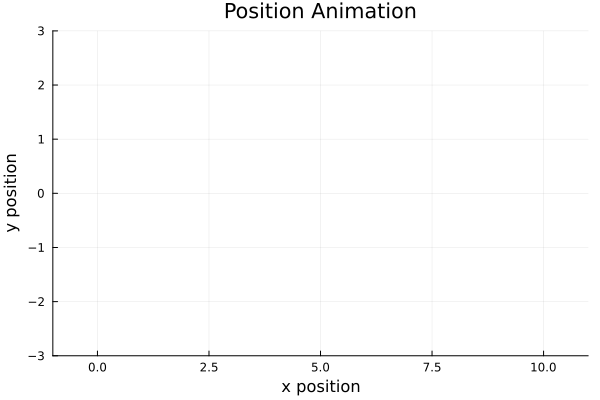

In [39]:
animation(robot_path, human_path, pos_xlims=[-1, 11])

In [45]:
function simulation_sweep(ego_ip::InteractionPlanner, other_ip::InteractionPlanner, sim_horizon, ego_boundary_conditions::Vector{Tuple{Vector{Float64}, Vector{Float64}}}, other_boundary_conditions::Vector{Tuple{Vector{Float64}, Vector{Float64}}}; ego_ibr_iterations=3::Int64, other_ibr_iterations=3::Int64)
    runs = maximum([length(ego_boundary_conditions), length(other_boundary_conditions)])

    ego_ego_hps = ego_ip.ego_planner.incon.hps
    ego_other_hps = ego_ip.other_planner.incon.hps
    other_ego_hps = other_ip.ego_planner.incon.hps
    other_other_hps = other_ip.other_planner.incon.hps

    @show ego_ibr_iterations, other_ibr_iterations

    if length(ego_boundary_conditions) == 1 
        for i in 1:(runs - 1)
            push!(ego_boundary_conditions, ego_boundary_conditions[1])
        end
    elseif length(other_boundary_conditions) == 1
        for i in 1:(runs - 1)
            push!(other_boundary_conditions, other_boundary_conditions[1])
        end
    end

    if length(ego_boundary_conditions) != length(other_boundary_conditions)
        throw(ArgumentError("length of 'ego_boundary_conditions' and 'other_boundary_conditions' must match"))
    end

    runs_dict = Dict{String, SimData}()

    for j in ProgressBar(1:runs)
        sim_ego_ip = InteractionPlanner(ego_ego_hps, ego_other_hps, ego_boundary_conditions[j][1], other_boundary_conditions[j][1], ego_boundary_conditions[j][2], other_boundary_conditions[j][2], "ECOS")
        sim_other_ip = InteractionPlanner(other_ego_hps, other_other_hps, other_boundary_conditions[j][1], ego_boundary_conditions[j][1], other_boundary_conditions[j][2], ego_boundary_conditions[j][2], "ECOS")

        ego_params = PlannerParams(sim_ego_ip.ego_planner.incon.hps, sim_ego_ip.ego_planner.incon.opt_params, sim_ego_ip.other_planner.incon.hps, sim_ego_ip.other_planner.incon.opt_params)
        other_params = PlannerParams(sim_other_ip.ego_planner.incon.hps, sim_other_ip.ego_planner.incon.opt_params, sim_other_ip.other_planner.incon.hps, sim_other_ip.other_planner.incon.opt_params)

        sim_params = IPSimParams(ego_params, other_params)

        ego_states, ego_controls, other_states, other_controls, solve_time = simulate_oc(sim_ego_ip, sim_other_ip, sim_horizon, ego_ibr_iterations=ego_ibr_iterations, other_ibr_iterations=other_ibr_iterations)

        sim_data = SimData(sim_params, solve_time, ego_states, ego_controls, other_states, other_controls)

        runs_dict["Run $(j)"] = sim_data

        # deleting variables
        sim_ego_ip = nothing
        sim_other_ip = nothing
        ego_params = nothing
        other_params = nothing
        sim_params = nothing
        ego_states = nothing
        ego_controls = nothing
        other_states = nothing
        other_controls = nothing
        sim_data = nothing
    end

    runs_dict
end

simulation_sweep (generic function with 3 methods)

In [46]:
robot_states = mohrs_circle_states(robot, [0., 0., 0., 0.], [10., 0., 0., 0.], pi / 6);

In [57]:
function run_experiment(ego_ip::InteractionPlanner, other_ip::InteractionPlanner, sim_horizon, ego_boundary_conditions::Vector{Tuple{Vector{Float64}, Vector{Float64}}}, other_boundary_conditions::Vector{Tuple{Vector{Float64}, Vector{Float64}}}; ego_ibr_iterations=3::Int64, other_ibr_iterations=3::Int64, save_path=""::String)
    start_time = time()
    println("-" ^ 80)
    println("Running Simulations")
    println("-" ^ 80)
    sweep_data = simulation_sweep(ego_ip, other_ip, sim_horizon, ego_boundary_conditions, other_boundary_conditions, ego_ibr_iterations=ego_ibr_iterations, other_ibr_iterations=other_ibr_iterations)
    println("-" ^ 80)
    println("Evaluating Simulations")
    println("-" ^ 80)
    metrics = evaluate_sim(sweep_data)
    end_time = time()
    if save_path != ""
        serialize(save_path, metrics)
    end

    print("Experiment finished in $(end_time - start_time)")

    metrics
end

run_experiment (generic function with 6 methods)

In [25]:
metrics_test = run_experiment(robot_ip, human_ip, 50, robot_states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])], ego_ibr_iterations=1, other_ibr_iterations=1)

--------------------------------------------------------------------------------
Running Simulations
--------------------------------------------------------------------------------


0.0%┣                                               ┫ 0/12 [00:00<00:00, -0s/it]


8.3%┣███▋                                       ┫ 1/12 [00:11<Inf:Inf, InfGs/it]


16.7%┣███████▊                                      ┫ 2/12 [00:22<03:37, 22s/it]


25.0%┣███████████▌                                  ┫ 3/12 [00:33<02:26, 16s/it]


33.3%┣███████████████▍                              ┫ 4/12 [00:44<01:57, 15s/it]


41.7%┣███████████████████▏                          ┫ 5/12 [00:55<01:36, 14s/it]


50.0%┣███████████████████████                       ┫ 6/12 [01:06<01:19, 13s/it]


58.3%┣██████████████████████████▉                   ┫ 7/12 [01:17<01:04, 13s/it]


66.7%┣██████████████████████████████▊               ┫ 8/12 [01:28<00:50, 13s/it]


75.0%┣██████████████████████████████████▌           ┫ 9/12 [01:39<00:37, 12s/it]


83.3%┣█████████████████████████████████████▌       ┫ 10/12 [01:50<00:24, 12s/it]


91.7%┣█████████████████████████████████████████▎   ┫ 11/12 [02:01<00:12, 12s/it]


--------------------------------------------------------------------------------
Evaluating Simulations
--------------------------------------------------------------------------------


100.0%┣████████████████████████████████████████████┫ 12/12 [02:13<00:00, 12s/it]
100.0%┣████████████████████████████████████████████┫ 12/12 [02:13<00:00, 12s/it]
0.0%┣                                               ┫ 0/12 [00:00<00:00, -0s/it]


51515151

8.3%┣███▋                                       ┫ 1/12 [00:00<Inf:Inf, InfGs/it]
16.7%┣███████▉                                       ┫ 2/12 [00:00<00:02, 5it/s]


51515151

25.0%┣███████████▊                                   ┫ 3/12 [00:00<00:01, 7it/s]


33.3%┣███████████████▊                               ┫ 4/12 [00:00<00:01, 7it/s]


51515151

41.7%┣███████████████████▋                           ┫ 5/12 [00:01<00:01, 8it/s]
50.0%┣███████████████████████▌                       ┫ 6/12 [00:01<00:01, 8it/s]


51515151

58.3%┣███████████████████████████▍                   ┫ 7/12 [00:01<00:01, 9it/s]
66.7%┣███████████████████████████████▍               ┫ 8/12 [00:01<00:00, 9it/s]


5151

75.0%┣███████████████████████████████████▎           ┫ 9/12 [00:01<00:00, 9it/s]


51515151

83.3%┣██████████████████████████████████████▍       ┫ 10/12 [00:01<00:00, 9it/s]
91.7%┣██████████████████████████████████████████▏   ┫ 11/12 [00:01<00:00, 9it/s]


5151Experiment finished in 133.94443893432617

100.0%┣█████████████████████████████████████████████┫ 12/12 [00:01<00:00, 9it/s]
100.0%┣█████████████████████████████████████████████┫ 12/12 [00:01<00:00, 9it/s]


Dict{String, SimMetrics} with 12 entries:
  "Run 4"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 10" => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 1"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 11" => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 6"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 12" => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 2"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 9"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 5"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 8"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 7"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerHyperparamete…
  "Run 3"  => SimMetrics(SimData(IPSimParams(PlannerParams(PlannerH

In [26]:
display_data(metrics_test)

GtkLabelLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=100, margin=100, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=TRUE, expand=FALSE, scale-factor=1, xpad, ypad, label="<b><u>Sim 12 Metrics</u></b>
<b> </b> 
<b>Ego Average Acceleration = </b>0.2999
<b>Other Average Acceleration = </b>0.299
<b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b

In [ ]:
function run_experiment(ego_ip::InteractionPlanner, other_ip::InteractionPlanner, sim_horizon, ego_boundary_conditions::Vector{Tuple{Vector{Float64}, Vector{Float64}}}, other_boundary_conditions::Vector{Tuple{Vector{Float64}, Vector{Float64}}}; ego_ibr_iterations=3::Int64, other_ibr_iterations=3::Int64, save_path=""::String)
    start_time = time()
    println("-" ^ 80)
    println("Running Simulations")
    println("-" ^ 80)
    sweep_data = simulation_sweep(ego_ip, other_ip, sim_horizon, ego_boundary_conditions, other_boundary_conditions, ego_ibr_iterations=ego_ibr_iterations, other_ibr_iterations=other_ibr_iterations)
    println("-" ^ 80)
    println("Evaluating Simulations")
    println("-" ^ 80)
    metrics = evaluate_sim(sweep_data)
    end_time = time()
    if save_path != ""
        serialize(save_path, metrics)
    end

    print("Experiment finished in $(end_time - start_time)")

    metrics
end

# Inconvenience Budget